#### This is used to go in the same directory as when everything is run under Pycharm in a normal python file

In [1]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\Fede\Documents\GitHub\RelGAN\src\topic_modelling


In [2]:
os.chdir("..")
cwd = os.getcwd()
print(cwd)
assert cwd.endswith("src")

C:\Users\Fede\Documents\GitHub\RelGAN\src


Qua dobbiamo avere RelGAN

### Test new data_loader

In [16]:
import numpy as np
from nltk.stem import PorterStemmer as ps
import random, time
import gc
gc.collect()

10078

In [4]:
from topic_modelling.lda_topic import train_specific_LDA, get_corpus, LDA

coco = True
corpus_raw = get_corpus(coco)
lda = train_specific_LDA(corpus_raw, num_top=3, passes=2, iterations=2, chunksize=2000, coco=coco)

Model loaded


In [11]:
corpus_raw

['a bicycle replica with a clock as the front wheel.',
 'a black honda motorcycle parked in front of a garage.',
 'a room with blue walls and a white sink and door.',
 'a car that seems to be parked illegally behind a legally parked car',
 'a large passenger airplane flying through the air.',
 'there is a gol plane taking off in a partly cloudy sky.',
 'blue and white color scheme in a small bathroom.',
 'this is a blue and white bathroom with a wall sink and a lifesaver on the wall.',
 'a blue boat themed bathroom with a life preserver on the wall',
 'the bike has a clock as a tire.',
 'a honda motorcycle parked in a grass driveway',
 'two cars parked on the sidewalk on the street',
 'an airplane that is, either, landing or just taking off.',
 'a bathroom with walls that are painted baby blue.',
 'a bathroom with a toilet, sink, and shower.',
 'a long empty, minimal modern skylit home kitchen.',
 'an office cubicle with four different types of computers.',
 'a bathroom sink with toile

In [12]:
lda_model = lda.lda_model
from gensim.models import LdaModel

assert isinstance(lda_model, LdaModel)
lda_model

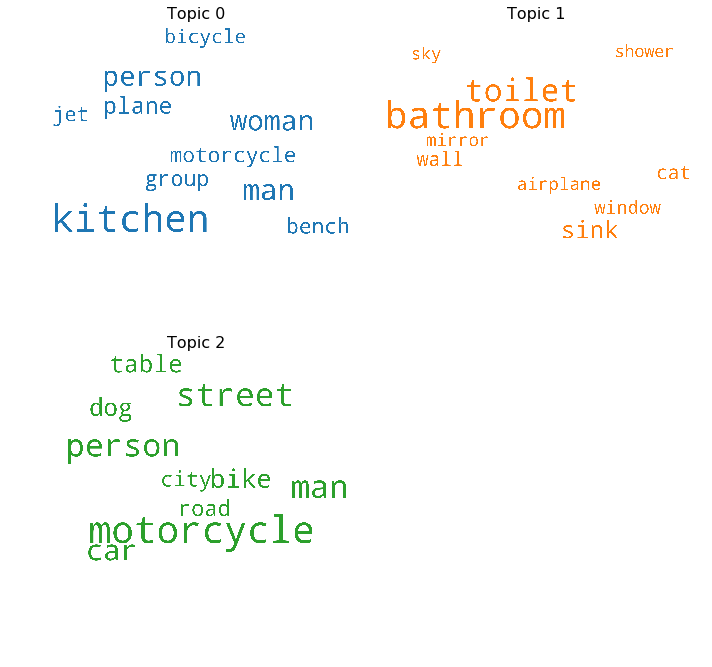

In [15]:
from src.topic_modelling.lda_utils import word_cloud
%matplotlib inline

word_cloud(lda)

#### Calcolo del real_topic_vector in base al numero di topic inserito

In [58]:
def compute_real_topic_vector(model_word_index_dict, topic_num=3):
    t = time.time()
    from topic_modelling.lda_topic import train_specific_LDA, get_corpus, LDA

    # Create LDA model for the dataset, given parameters
    coco = True if "coco" in data_file else False  # Now it is just coco or not coco just for name saving reasons
    corpus_raw = get_corpus(coco, datapath=data_file)
    lda = train_specific_LDA(corpus_raw, num_top=topic_num, passes=2, iterations=2, chunksize=2000, coco=coco)

    # Get percentage of each topic in each sentence
    df = get_perc_sent_topic(ldamodel=lda.lda_model, corpus=lda.corpus_bow, texts=lda.corpus_text, stops=lda.stops, topic_num=topic_num)
    print(df.columns)
    assert(len(df.columns) == topic_num + 2)
    topic_matrix = lda.lda_model.get_topics()  # num_topic x num_words
    topic_weights = df.values[:, 1:topic_num + 1]  # num_sentences x num_topic (each row sum to 1)
    topic_sentences = np.dot(topic_weights, topic_matrix)  # num_sentences x num_word
    topic_sentences = np.divide(topic_sentences,
                                np.sum(topic_sentences, axis=1, keepdims=True))  # rowwise normalization

    # get model lemmatized version of the words, it's needed because LDA does it and model processing doesn't
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    texts = [lemmatizer.lemmatize(word) for word in model_word_index_dict.keys()]
    lda_index_word_dict = lda.dictionary.id2token
    
    def get_model_index(lda_index, texts, model_word_index_dict):
        word = lda_index_word_dict[lda_index]
        from_lemmatize = [text_index for text_index in range(len(texts)) if texts[text_index] == word]
        try:
            return [int(model_word_index_dict[word])] + from_lemmatize
        except KeyError:
            return from_lemmatize
        
    real_vector = np.zeros((topic_sentences.shape[0], len(model_word_index_dict) + 1))  # sentence_number x vocab_size
    inverse_indexes = [get_model_index(i, texts, model_word_index_dict) for i in range(len(lda_index_word_dict))]
    print("number of LDA words: {}".format(len(lda_index_word_dict)))

    # since the parallelism is the same for each sentence, it is done word by word for all sentences all together.
    # It is possible that a word in the LDA corresponds to more words in the model due to lemmatization procedure
    for ind, invere_index in enumerate(inverse_indexes):
        # more than one index in the model because of lemmatization
        for x in invere_index:
            real_vector[:, x] = topic_sentences[:, ind]

    print("Topic model computed in {} sec!".format(time.time() - t))
    gc.collect()
    return real_vector

#### Create Topic Vector for sentences in the dataset

In [64]:
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet

from gensim.utils import lemmatize, simple_tokenize

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def process_texts(input_texts, stops):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    final = []
    for i in input_texts:
        texts = (re.sub(r"http\S+", "", i))
        # tokenize
        texts = simple_tokenize(texts)
        # lower case
        texts = [word.lower() for word in texts]
        # remove stopwords
        texts = [word for word in texts if word not in stops]

        # automatically detect common phrases
        sentence = ' '.join(texts)
        texts = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        # texts = [str(word).split('/')[0].split('b\'')[1] for word in lemmatizer.lemmatize(sentence)]  # , allowed_tags=re.compile('(NN)'), min_length=2)]

        final.append(texts)
    return final

def get_perc_sent_topic(ldamodel, corpus, texts, stops, topic_num):
    # Init output
    sent_topics_df = pd.DataFrame()
    texts = process_texts(texts, stops)

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        #print(row)
        # row = sorted(row, key=lambda x: (x[1]), reverse=True) # sort list to get dominant topic
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        to_append = np.zeros(topic_num)
        for j, (topic_n, prop_topic) in enumerate(row):
            # if j == 0:  # => dominant topic
            #     wp = ldamodel.show_topic(topic_num)
            #     topic_keywords = ", ".join([word for word, prop in wp])
            #     sent_topics_df = sent_topics_df.append(
            #         pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            # else:
            #     break
            to_append[topic_n] = prop_topic
        sent_topics_df = sent_topics_df.append(pd.Series(to_append), ignore_index=True)
        #print(len(to_append))
    print(to_append)
    sent_topics_df.columns = ["Topic {}".format(topic_number) for topic_number in range(len(to_append))]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = sent_topics_df.reset_index()
    return sent_topics_df


In [17]:
from src.topic_modelling.lda_topic import get_dominant_topic_and_contribution

df = get_perc_sent_topic(ldamodel=lda.lda_model, corpus=lda.corpus_bow, texts=lda.corpus_text, stops=lda.stops)

In [18]:
df.head(5)

,index,Topic 0,Topic 1,Topic 2,0
0,0,0.526208,0.369791,0.104001,"[bicycle, replica, clock, front, wheel]"
1,1,0.463529,0.096081,0.440390,"[black, honda, motorcycle, park, front, garage]"
2,2,0.094993,0.700150,0.204857,"[room, blue, wall, white, sink, door]"
3,3,0.118244,0.117363,0.764393,"[car, seem, park, illegally, behind, legally, ..."
4,4,0.668458,0.217928,0.113614,"[large, passenger, airplane, fly, air]"


In [19]:
topic_matrix = lda.lda_model.get_topics() #  3 topics * 2280 words

In [20]:
topic_num = 3
topic_weights = df.values[:, 1:topic_num + 1]
sentences_number = topic_weights.shape[0]
word_count = topic_matrix.shape[1]
size = ((int(sentences_number), int(word_count)))
print("Topic sentnece dim: {}".format(size))
topic_sentences = np.zeros(size)

Topic sentnece dim: (10000, 2280)


In [21]:
topic_weights[:, 0]

array([0.5262081623077393, 0.46352916955947876, 0.09499283879995346, ...,
       0.11363085359334946, 0.5270355939865112, 0.8309606909751892],
      dtype=object)

In [22]:
for index in range(topic_sentences.shape[0]):
    topic_sentences[index] = np.dot(np.expand_dims(topic_weights[index], 0), topic_matrix).squeeze()
topic_sentences = np.divide(topic_sentences,np.sum(topic_sentences, axis=1, keepdims=True))

In topic_sentneces ho per ogni sentence il topic 'pesato'

In [23]:
index_dict = lda.dictionary
index

9999

than I have to make this vector of the same size of the vector used by the model (circa 4k) keeping the parallelism between words

In [10]:
from path_resolution import resources_path
from utils.text_process import text_precess
dataset = "image_coco"
data_file = resources_path("data", '{}.txt'.format(dataset))
seq_len, vocab_size, word_index_dict, index_word_dict = text_precess(data_file)

In [11]:
lda_word_index_dict = lda.dictionary.token2id
model_index_word_dict = {v: k for k, v in word_index_dict.items()}
lda_index_word_dict = lda.dictionary.id2token
model_word_index_dict = word_index_dict

In [26]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
texts = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in model_word_index_dict.keys()]

def get_model_index(lda_index):
    word = lda_index_word_dict[lda_index]
    #print("{} is word {}".format(lda_index, word))
    try:
        return model_word_index_dict[word]
    except KeyError:
        return [index for index in range(len(texts)) if texts[index] == word]

real_vector = np.zeros((topic_sentences.shape[0], len(model_index_word_dict)))
inverse_indexes = [get_model_index(i) for i in range(len(lda_index_word_dict))]

In [28]:
model_word_index_dict['a']

'1858'

In [29]:
len(lda_index_word_dict)

2280

In [30]:
for ind, invere_index in enumerate(inverse_indexes):
    if isinstance(invere_index, list):
        # more than one index in the model because of lemmatization
        for x in invere_index:
            real_vector[:, x] = topic_sentences[:, ind]
    else:
        invere_index = int(invere_index)
        real_vector[:, invere_index] = topic_sentences[:, ind] 

Adesso nel real vector (num_sentences, model_word_number) c'è il topic vector estratto da LDA per ogni frase nel modello

In [31]:
real_vector_without_zeros = real_vector[~(real_vector==0)].reshape(10000, -1)

In [32]:
df_real_vector = pd.DataFrame(data=real_vector_without_zeros,    # values
                    index=range(real_vector_without_zeros.shape[0]),    # 1st column as index
                    columns=range(real_vector_without_zeros.shape[1])) 

In [76]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#x = range(real_vector_without_zeros.shape[1])
i= 3
#df_real_vector[df_real_vector.columns[60*i:(i+1)*60]].boxplot()
#ax = sns.lineplot(x="words", y="% of word in topic distrib", data=df_real_vector)

In [90]:
real_vector_40.mean(axis=0).shape

(4682,)

In [92]:
dict_index_mean = {}
for ind, m in enumerate(real_vector_6.mean(axis=0)):
    dict_index_mean[str(ind)] = m

In [93]:
mean_list = []
for word, mean in zip(model_index_word_dict.values(), dict_index_mean.values()):
    mean_list.append((word, mean))

In [94]:
mean_list.sort(key = lambda x: x[1], reverse = True) 

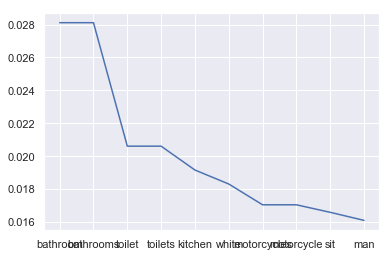

In [91]:
mean_list_reduced = mean_list[:10]
plt.plot([x[0] for x in mean_list_reduced], [x[1] for x in mean_list_reduced])
#plt.set_yscale("log", nonposy='clip')
plt.show()

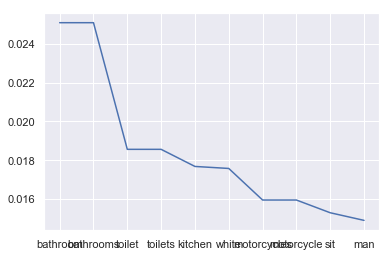

In [95]:
mean_list_reduced = mean_list[:10]
plt.plot([x[0] for x in mean_list_reduced], [x[1] for x in mean_list_reduced])
#plt.set_yscale("log", nonposy='clip')
plt.show()

In [ ]:
mean_list_reduced

In [45]:
model_index_word_dict['2']

'heats'

In [61]:
# Check that the correspondance is correct
index = 34
lda_word = lda_index_word_dict[index]
model_word = model_index_word_dict[get_model_index(index)]
print(lda_word, model_word)

toilet toilet


#### Ora provo a stampare alcune frasi e le parole più significative uscenti dalla somma pesata del topic

In [33]:
def print_sentence_important_words(real_vector_custom, model_index_word_dict):
    sentence_num = len(corpus_raw)
    index = random.randint(0, sentence_num)
    sentence = corpus_raw[index]
    weighted_topic_sentence = real_vector_custom[index]
    ordered_index = np.argsort(-weighted_topic_sentence)[:10]
    print("Sentence with index {}: \"{}\"".format(index, sentence))
    for i in ordered_index:
        print(model_index_word_dict[str(i)], i, weighted_topic_sentence[i])

## Comparing different number of topics
Voglio capire quali sono le top words, che sono quelle che influenzeranno il modello maggiormente, in base alla frase in base al numero di topic utilizzato

In [57]:
real_vector_6 = compute_real_topic_vector(model_word_index_dict, topic_num=6)

Model loaded
[(0, 0.4557897), (1, 0.03417711), (2, 0.21950176), (3, 0.122870706), (4, 0.12194712), (5, 0.045713596)]
6
[(0, 0.029065508), (1, 0.23834485), (2, 0.06507509), (3, 0.055400334), (4, 0.5863975), (5, 0.025716668)]
6
[(0, 0.024290923), (1, 0.5726688), (2, 0.13168624), (3, 0.026407314), (4, 0.024354829), (5, 0.22059193)]
6
[(0, 0.019937402), (1, 0.03986129), (2, 0.070469454), (3, 0.032403413), (4, 0.52689254), (5, 0.3104359)]
6
[(0, 0.028051237), (1, 0.030607454), (2, 0.8243814), (3, 0.041149758), (4, 0.027824838), (5, 0.047985293)]
6
[(0, 0.02579169), (1, 0.0244477), (2, 0.87765664), (3, 0.024089169), (4, 0.023926048), (5, 0.0240887)]
6
[(0, 0.024883484), (1, 0.78478646), (2, 0.08806616), (3, 0.031700015), (4, 0.024548965), (5, 0.046014883)]
6
[(0, 0.02156148), (1, 0.83508176), (2, 0.051767517), (3, 0.024846219), (4, 0.021743942), (5, 0.044999104)]
6
[(0, 0.14715606), (1, 0.6721719), (2, 0.06038458), (3, 0.03193671), (4, 0.02305312), (5, 0.06529766)]
6
[(0, 0.2457666), (1, 0.0

[(0, 0.03339179), (1, 0.054142304), (2, 0.035888188), (3, 0.19345433), (4, 0.64720064), (5, 0.03592277)]
6
[(0, 0.49498516), (1, 0.03079212), (2, 0.030630633), (3, 0.31804517), (4, 0.023989731), (5, 0.10155721)]
6
[(0, 0.18315408), (1, 0.02778426), (2, 0.70562714), (3, 0.0277942), (4, 0.02783202), (5, 0.027808327)]
6
[(0, 0.113723844), (1, 0.69828844), (2, 0.08774293), (3, 0.028001597), (4, 0.032724146), (5, 0.039519023)]
6
[(0, 0.055970225), (1, 0.025354527), (2, 0.3947728), (3, 0.08034241), (4, 0.16818783), (5, 0.27537224)]
6
[(0, 0.58188856), (1, 0.04292113), (2, 0.1822493), (3, 0.089912675), (4, 0.070950784), (5, 0.032077607)]
6
[(0, 0.03464882), (1, 0.35705647), (2, 0.16396624), (3, 0.11228059), (4, 0.027956575), (5, 0.30409127)]
6
[(0, 0.03571233), (1, 0.027819416), (2, 0.034556165), (3, 0.033626754), (4, 0.8243232), (5, 0.043962106)]
6
[(0, 0.09646458), (1, 0.075118825), (2, 0.7541883), (3, 0.024960393), (4, 0.024988838), (5, 0.024279064)]
6
[(0, 0.038804065), (1, 0.116642885), 

6
[(0, 0.20635425), (1, 0.034067232), (2, 0.041195836), (3, 0.6018697), (4, 0.07429805), (5, 0.04221494)]
6
[(0, 0.2989309), (1, 0.020938829), (2, 0.024731241), (3, 0.38413316), (4, 0.051225882), (5, 0.22003996)]
6
[(0, 0.18563701), (1, 0.030233113), (2, 0.06726876), (3, 0.232962), (4, 0.440674), (5, 0.043225132)]
6
[(0, 0.028570784), (1, 0.027793953), (2, 0.40075898), (3, 0.48709688), (4, 0.0278718), (5, 0.027907647)]
6
[(0, 0.28142476), (1, 0.028421776), (2, 0.05479142), (3, 0.20767581), (4, 0.1101933), (5, 0.31749293)]
6
[(0, 0.03480264), (1, 0.03345859), (2, 0.2700311), (3, 0.17883427), (4, 0.3788258), (5, 0.1040476)]
6
[(0, 0.03359037), (1, 0.8318207), (2, 0.033793706), (3, 0.03361078), (4, 0.03357929), (5, 0.03360513)]
6
[(0, 0.028288776), (1, 0.023824127), (2, 0.025968209), (3, 0.035578698), (4, 0.86200595), (5, 0.024334239)]
6
[(0, 0.054730102), (1, 0.022495154), (2, 0.088362046), (3, 0.09738071), (4, 0.710621), (5, 0.026411)]
6
[(0, 0.027486281), (1, 0.08940614), (2, 0.0209732

[(0, 0.34356743), (1, 0.28641915), (2, 0.029810594), (3, 0.28249428), (4, 0.027790394), (5, 0.029918129)]
6
[(0, 0.032711547), (1, 0.04074044), (2, 0.39857936), (3, 0.09334479), (4, 0.13176155), (5, 0.3028623)]
6
[(0, 0.033587128), (1, 0.037194908), (2, 0.7875545), (3, 0.0642199), (4, 0.033414196), (5, 0.044029407)]
6
[(0, 0.051615823), (1, 0.0334362), (2, 0.1265552), (3, 0.09227535), (4, 0.6196278), (5, 0.07648965)]
6
[(0, 0.07193756), (1, 0.02465528), (2, 0.16046877), (3, 0.102587014), (4, 0.5816825), (5, 0.05866888)]
6
[(0, 0.034386422), (1, 0.02713221), (2, 0.15762492), (3, 0.026655212), (4, 0.72502005), (5, 0.02918118)]
6
[(0, 0.03782311), (1, 0.031833313), (2, 0.024220308), (3, 0.24755844), (4, 0.6182668), (5, 0.04029796)]
6
[(0, 0.033441868), (1, 0.0424836), (2, 0.0401809), (3, 0.15778142), (4, 0.53278154), (5, 0.19333069)]
6
[(0, 0.024112705), (1, 0.028180188), (2, 0.5604013), (3, 0.03806652), (4, 0.32515082), (5, 0.024088487)]
6
[(0, 0.057502985), (1, 0.029569611), (2, 0.11977

6
[(0, 0.02467052), (1, 0.23082216), (2, 0.2593378), (3, 0.06803503), (4, 0.39272773), (5, 0.024406688)]
6
[(0, 0.14196374), (1, 0.44067392), (2, 0.032074798), (3, 0.21946284), (4, 0.032348752), (5, 0.13347599)]
6
[(0, 0.024503535), (1, 0.02590542), (2, 0.06018857), (3, 0.08360383), (4, 0.77961), (5, 0.026188655)]
6
[(0, 0.27066866), (1, 0.10098848), (2, 0.16854855), (3, 0.0646085), (4, 0.07625373), (5, 0.31893212)]
6
[(0, 0.032425616), (1, 0.41614595), (2, 0.028976392), (3, 0.0886882), (4, 0.4047947), (5, 0.028969174)]
6
[(0, 0.027787358), (1, 0.8605776), (2, 0.027782578), (3, 0.0278401), (4, 0.027781101), (5, 0.02823129)]
6
[(0, 0.041683566), (1, 0.78924704), (2, 0.041670986), (3, 0.043403994), (4, 0.0416696), (5, 0.04232481)]
6
[(0, 0.04970939), (1, 0.25142735), (2, 0.13737805), (3, 0.34686124), (4, 0.18896167), (5, 0.025662346)]
6
[(0, 0.02553433), (1, 0.15485792), (2, 0.31169575), (3, 0.02384526), (4, 0.023821408), (5, 0.46024528)]
6
[(0, 0.24444993), (1, 0.14156614), (2, 0.160579

6
[(0, 0.054511223), (1, 0.2919007), (2, 0.099964306), (3, 0.07598207), (4, 0.033535734), (5, 0.44410598)]
6
[(0, 0.041697647), (1, 0.0417956), (2, 0.50565237), (3, 0.32655233), (4, 0.04169424), (5, 0.04260781)]
6
[(0, 0.08270141), (1, 0.028454812), (2, 0.23232652), (3, 0.09684821), (4, 0.31013888), (5, 0.24953018)]
6
[(0, 0.08436039), (1, 0.027784912), (2, 0.29181218), (3, 0.05064053), (4, 0.5171882), (5, 0.028213827)]
6
[(0, 0.31106263), (1, 0.2829515), (2, 0.17690203), (3, 0.14812453), (4, 0.052301638), (5, 0.028657708)]
6
[(0, 0.044075817), (1, 0.03467787), (2, 0.28209752), (3, 0.0796981), (4, 0.23046125), (5, 0.3289894)]
6
[(0, 0.02950896), (1, 0.05509478), (2, 0.28602186), (3, 0.032437596), (4, 0.033404708), (5, 0.5635321)]
6
[(0, 0.52330935), (1, 0.033637896), (2, 0.037099965), (3, 0.041273538), (4, 0.15226316), (5, 0.21241608)]
6
[(0, 0.039000064), (1, 0.10349812), (2, 0.0343775), (3, 0.054150857), (4, 0.7245101), (5, 0.044463392)]
6
[(0, 0.02514982), (1, 0.020307364), (2, 0.21

6
[(0, 0.034385726), (1, 0.059276216), (2, 0.81728476), (3, 0.027875036), (4, 0.027955217), (5, 0.03322299)]
6
[(0, 0.032981418), (1, 0.028617514), (2, 0.035296757), (3, 0.025584076), (4, 0.049697645), (5, 0.82782257)]
6
[(0, 0.05777261), (1, 0.13633536), (2, 0.117224276), (3, 0.04083861), (4, 0.43259522), (5, 0.21523388)]
6
[(0, 0.10376481), (1, 0.14726561), (2, 0.22412647), (3, 0.044271614), (4, 0.063311204), (5, 0.41726026)]
6
[(0, 0.03855458), (1, 0.04217239), (2, 0.19491084), (3, 0.2870647), (4, 0.20159063), (5, 0.23570684)]
6
[(0, 0.07815409), (1, 0.025433414), (2, 0.06845641), (3, 0.44000375), (4, 0.1230923), (5, 0.26486003)]
6
[(0, 0.20262827), (1, 0.030559432), (2, 0.36541083), (3, 0.3391929), (4, 0.03284776), (5, 0.029360812)]
6
[(0, 0.17955841), (1, 0.038532976), (2, 0.05203645), (3, 0.25063056), (4, 0.44016024), (5, 0.039081365)]
6
[(0, 0.030623777), (1, 0.028744247), (2, 0.15986438), (3, 0.6588547), (4, 0.08639226), (5, 0.035520677)]
6
[(0, 0.032960806), (1, 0.093672924), 

[(0, 0.42263475), (1, 0.030651422), (2, 0.11452894), (3, 0.06819517), (4, 0.330406), (5, 0.033583663)]
6
[(0, 0.36170503), (1, 0.028858054), (2, 0.048376963), (3, 0.47561577), (4, 0.044438884), (5, 0.04100533)]
6
[(0, 0.13728271), (1, 0.033755925), (2, 0.30081606), (3, 0.43657744), (4, 0.029437728), (5, 0.06213016)]
6
[(0, 0.13770989), (1, 0.3709666), (2, 0.033111002), (3, 0.1190887), (4, 0.069750145), (5, 0.26937363)]
6
[(0, 0.12108415), (1, 0.030772401), (2, 0.0979333), (3, 0.4445986), (4, 0.23732506), (5, 0.06828646)]
6
[(0, 0.5045179), (1, 0.08569788), (2, 0.027944582), (3, 0.30863068), (4, 0.034703404), (5, 0.038505554)]
6
[(0, 0.03387189), (1, 0.03073209), (2, 0.46064705), (3, 0.11859034), (4, 0.31003588), (5, 0.046122696)]
6
[(0, 0.59341174), (1, 0.033647697), (2, 0.12726761), (3, 0.03651986), (4, 0.17483021), (5, 0.03432288)]
6
[(0, 0.12558547), (1, 0.04728392), (2, 0.028127), (3, 0.029131308), (4, 0.7314664), (5, 0.038405906)]
6
[(0, 0.30126572), (1, 0.3628959), (2, 0.1020647)

6
[(0, 0.050265286), (1, 0.06238957), (2, 0.12086105), (3, 0.12361239), (4, 0.09604746), (5, 0.5468242)]
6
[(0, 0.028780969), (1, 0.85669035), (2, 0.027867751), (3, 0.028865878), (4, 0.027848268), (5, 0.029946724)]
6
[(0, 0.024507923), (1, 0.7200191), (2, 0.07216398), (3, 0.07982646), (4, 0.025369735), (5, 0.07811278)]
6
[(0, 0.033346698), (1, 0.49780566), (2, 0.033426706), (3, 0.034254678), (4, 0.033371616), (5, 0.3677946)]
6
[(0, 0.041370083), (1, 0.09724083), (2, 0.20858684), (3, 0.12556715), (4, 0.07701858), (5, 0.4502165)]
6
[(0, 0.02833953), (1, 0.8562407), (2, 0.027858915), (3, 0.029642563), (4, 0.027847094), (5, 0.030071244)]
6
[(0, 0.02397116), (1, 0.84859407), (2, 0.023936553), (3, 0.025283057), (4, 0.05328163), (5, 0.024933547)]
6
[(0, 0.09041574), (1, 0.026140802), (2, 0.044449884), (3, 0.34835392), (4, 0.44834667), (5, 0.04229297)]
6
[(0, 0.05086936), (1, 0.7256938), (2, 0.03824719), (3, 0.10121125), (4, 0.047212873), (5, 0.036765527)]
6
[(0, 0.06161924), (1, 0.028914552),

6
[(0, 0.027865054), (1, 0.029519394), (2, 0.8423598), (3, 0.044440888), (4, 0.02781737), (5, 0.027997525)]
6
[(0, 0.5322622), (1, 0.0319654), (2, 0.03357714), (3, 0.20139861), (4, 0.028624406), (5, 0.17217219)]
6
[(0, 0.16506863), (1, 0.026614219), (2, 0.025908286), (3, 0.026456034), (4, 0.12203517), (5, 0.6339177)]
6
[(0, 0.42711583), (1, 0.022369394), (2, 0.027736938), (3, 0.023864707), (4, 0.3386543), (5, 0.16025881)]
6
[(0, 0.048418462), (1, 0.05293823), (2, 0.20250954), (3, 0.047418997), (4, 0.035319228), (5, 0.6133955)]
6
[(0, 0.042471338), (1, 0.47977948), (2, 0.027796289), (3, 0.39389452), (4, 0.028031731), (5, 0.028026642)]
6
[(0, 0.028311508), (1, 0.6598791), (2, 0.030831287), (3, 0.14063938), (4, 0.034195744), (5, 0.10614302)]
6
[(0, 0.03539993), (1, 0.036495283), (2, 0.6903271), (3, 0.17039621), (4, 0.033370093), (5, 0.034011334)]
6
[(0, 0.10567731), (1, 0.7813289), (2, 0.027861342), (3, 0.028196564), (4, 0.027992263), (5, 0.02894359)]
6
[(0, 0.035181902), (1, 0.056216046)

[(0, 0.03963015), (1, 0.6266695), (2, 0.033407908), (3, 0.03760324), (4, 0.033349138), (5, 0.22934008)]
6
[(0, 0.622233), (1, 0.2087907), (2, 0.077374294), (3, 0.034279425), (4, 0.027835926), (5, 0.029486654)]
6
[(0, 0.41814727), (1, 0.107076295), (2, 0.05562636), (3, 0.056083795), (4, 0.30743524), (5, 0.05563106)]
6
[(0, 0.8257789), (1, 0.02797318), (2, 0.027782079), (3, 0.062043678), (4, 0.027786369), (5, 0.02863574)]
6
[(0, 0.020849042), (1, 0.7213976), (2, 0.021075863), (3, 0.141785), (4, 0.020842347), (5, 0.074050136)]
6
[(0, 0.054237783), (1, 0.024003703), (2, 0.8470631), (3, 0.024332073), (4, 0.024411527), (5, 0.025951777)]
6
[(0, 0.60372186), (1, 0.16168617), (2, 0.026879122), (3, 0.0747658), (4, 0.023930177), (5, 0.10901688)]
6
[(0, 0.7129638), (1, 0.027936652), (2, 0.028028758), (3, 0.028367843), (4, 0.027817685), (5, 0.1748852)]
6
[(0, 0.03320388), (1, 0.40073562), (2, 0.025632003), (3, 0.35151845), (4, 0.028420635), (5, 0.16048938)]
6
[(0, 0.2567881), (1, 0.03353547), (2, 0

KeyboardInterrupt: 

In [34]:
print_sentence_important_words(real_vector_6, model_index_word_dict)

Sentence with index 2878: "the man is using a mouse looking at the computer."
kitchen 4040 0.026092305128044998
toilet 1211 0.024509961799205223
toilets 2102 0.024509961799205223
sit 3956 0.017114188336815706
women 418 0.01614097481841157
woman 2723 0.01614097481841157
cats 4507 0.01360850861302759
cat 4476 0.01360850861302759
man 1901 0.012506562433123402
mans 4037 0.012506562433123402


In [66]:
real_vector_40 = compute_real_topic_vector(model_word_index_dict, topic_num=40)

Model loaded
[0.         0.         0.17446515 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.19084856 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.5007959  0.         0.         0.        ]
Index([   'index',  'Topic 0',  'Topic 1',  'Topic 2',  'Topic 3',  'Topic 4',
        'Topic 5',  'Topic 6',  'Topic 7',  'Topic 8',  'Topic 9', 'Topic 10',
       'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16',
       'Topic 17', 'Topic 18', 'Topic 19', 'Topic 20', 'Topic 21', 'Topic 22',
       'Topic 23', 'Topic 24', 'Topic 25', 'Topic 26', 'Topic 27', 'Topic 28',
       'Topic 29', 'Topic 30', 'Topic 31', 'Topic 32', 'Topic 33', 'Topic 34',
       'Topic 35', 'Topic 36', 'Topic 37', 'Topic 38', 'Topic 39',          0],
      dtype='object')
number of L

In [103]:
print_sentence_important_words(real_vector_40, model_index_word_dict)

Sentence with index 3430: "a computer desk holding a computer monitor, a keyboard and a cup of coffee."
computers 3246 0.06891970075403817
computer 2775 0.06891970075403817
desks 2103 0.05159383779738227
desk 4547 0.05159383779738227
man 1901 0.049210039896107366
mans 4037 0.049210039896107366
bicycles 3827 0.039411227971868974
bicycle 2331 0.039411227971868974
sit 3956 0.03465807473955356
laptops 661 0.028967738653056983


## Print topic distributions

In [20]:
import copy
df_topic = copy.copy(df)
df_topic.set_index('index', inplace=True)

In [65]:
gc.collect()

12016